In [2]:
from warnings import simplefilter
from joblib import parallel_backend
# ignore all warnings
simplefilter(action='ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix,classification_report,precision_score,recall_score,f1_score, roc_auc_score, log_loss
import time
import cuml
data = pd.read_csv("./archive/data/creditcard_csv.csv", true_values=["'1'"], false_values=["'0'"])
from imblearn import over_sampling, under_sampling

In [3]:
data['Class'].value_counts()

False    284315
True        492
Name: Class, dtype: int64

In [4]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
      #0 is False, 1 is True
    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return (TP, FP, TN, FN)

In [5]:
def train_test_model(model,X_train,y_train,X_val,y_val, title = '_norm_'):
    # tic = time.time()
    model.fit(X_train,y_train)
    # toc = time.time()
    
    predictions = model.predict(X_val)
    # cm = confusion_matrix(y_pred=predictions, y_true=y_val)
    # FP = cm.sum(axis=0) - np.diag(cm)  
    # FN = cm.sum(axis=1) - np.diag(cm)
    # TP = np.diag(cm)
    # TN = cm.sum() - (FP + FN + TP)
    TP, FP, TN, FN = perf_measure(y_val, predictions)

    # Sensitivity, hit rate, recall, or true positive rate
    # TPR = TP/(TP+FN)
    # Specificity or true negative rate
    try:
        TNR = TN/(TN+FP) 
    except:
        TNR = -100
    # Precision or positive predictive value
    try:
        PPV = TP/(TP+FP)
    except:
        PPV = -100    
    
    # Negative predictive value
    try:
        NPV = TN/(TN+FN)
    except:
        NPV = -100
    # Fall out or false positive rate
    try:
        FPR = FP/(FP+TN)
    except:
        FPR = -100
    # False negative rate
    try:
        FNR = FN/(TP+FN)
    except:
        FNR = -100
    # False discovery rate
    try:
        FDR = FP/(TP+FP)
    except:
        FDR = -100
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # time_taken = toc-tic
    accuracy = np.round(accuracy_score(y_val,predictions), 3)
    precision = np.round(precision_score(y_val,predictions), 3)
    recall = np.round(recall_score(y_val,predictions), 3)
    f1 = np.round(f1_score(y_val,predictions), 3)
    logl = np.round(log_loss(y_val, predictions), 3)
    # print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Model Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    # print('Benchmark: \% of fraudulent detections',np.count_nonzero(predictions)/492)
    # print("Classification Report:\n")
    # print(classification_report(y_val,predictions))
    # print("Area under ROC curve: ", roc_auc_score(y_val, predictions))
    print("Log loss: ", logl)
    print("Confusion Matrix:\n")
    ConfusionMatrixDisplay.from_estimator(model,X_val,y_val, colorbar=False)
    plt.savefig(title + '_CF.png')
    plt.show()
    return [accuracy, PPV, recall, NPV, FPR, TNR, FNR, FDR, f1, logl]
    # print("ROC curve:\n")
    # RocCurveDisplay.from_estimator(model,X_val,y_val)
    # plt.show()

## task 2: See which imbalance handling technique works best for a given algorithm.

In [6]:
labels = np.float64(data['Class'].values)
features = data.drop("Class", axis=1).to_numpy()
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, train_size=0.7)

In [12]:
#Over sampling

oversampler = over_sampling.RandomOverSampler(sampling_strategy="minority") #Minority class is over_sampled

#Under sampling

undersampler = under_sampling.RandomUnderSampler(sampling_strategy="majority") #Majority class is under_sampled

#SMOTE

smote = over_sampling.SMOTE(sampling_strategy="minority")

In [13]:
ovsp_features, ovsp_labels = oversampler.fit_resample(train_features, train_labels)
udsp_features, udsp_labels = undersampler.fit_resample(train_features, train_labels)
smote_features, smote_labels = smote.fit_resample(train_features, train_labels)

In [9]:
metric_array = ['Acc', 'Prec', 'Rec', 'N Pred v', 'FP rate*', 'TN rate', 'FN rate*', 'FDisc r*','F1', 'Logl*']

### SVM

Test size: 85443
Model Accuracy:  0.998
Total Precision:  0.0
Total Recall:  0.0
Total F1 Score:  0.0
Log loss:  0.063
Confusion Matrix:



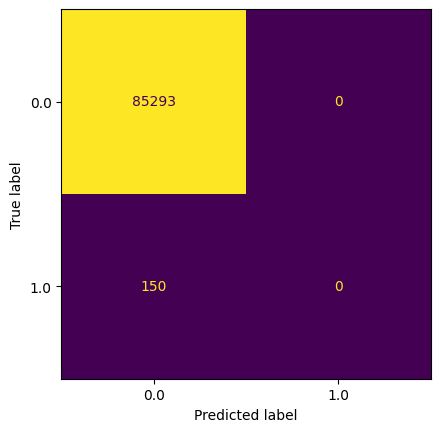

Test size: 85443
Model Accuracy:  0.443
Total Precision:  0.002
Total Recall:  0.707
Total F1 Score:  0.004
Log loss:  20.065
Confusion Matrix:



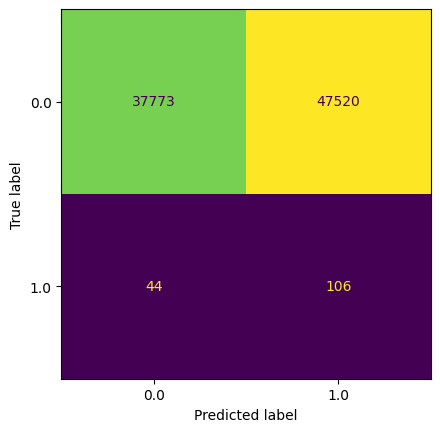

Test size: 85443
Model Accuracy:  0.539
Total Precision:  0.002
Total Recall:  0.54
Total F1 Score:  0.004
Log loss:  16.63
Confusion Matrix:



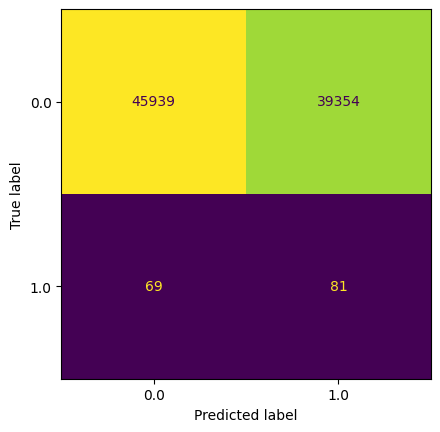

Test size: 85443
Model Accuracy:  0.443
Total Precision:  0.002
Total Recall:  0.707
Total F1 Score:  0.004
Log loss:  20.089
Confusion Matrix:



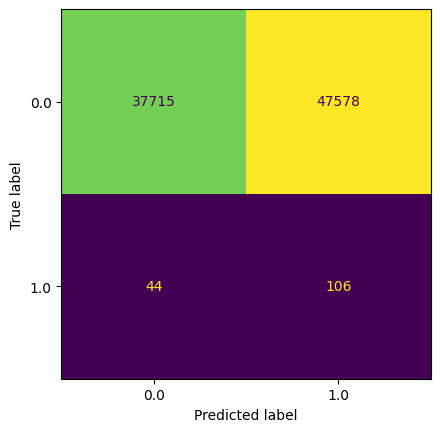

In [15]:
# with parallel_backend('threading', n_jobs=2):
svm_c = cuml.svm.SVC(C = 1.0)

svm0 = train_test_model(svm_c, train_features, train_labels, val_features, val_labels, title = './outputs/SVM/SVM_vanilla')
svm1 = train_test_model(svm_c, ovsp_features, ovsp_labels, val_features, val_labels, title = './outputs/SVM/SVM_ovsp')
svm2 = train_test_model(svm_c, udsp_features, udsp_labels, val_features, val_labels, title = './outputs/SVM/SVM_udsp')
svm3 = train_test_model(svm_c, smote_features, smote_labels, val_features, val_labels, title = './outputs/SVM/SVM_smote')
# svm4 = train_test_model(BaggingClassifier(svm.SVC()), train_features, train_labels, val_features, val_labels, title = './outputs/SVM/SVM_bag')
# svm5 = train_test_model(AdaBoostClassifier(svm.SVC()), train_features, train_labels, val_features, val_labels, title = './outputs/SVM/SVM_ada')

In [16]:
pd.DataFrame(np.vstack([svm0, svm1, svm2, svm3]).T, index = metric_array, columns = ['Vanilla', 'Over', 'Under', 'Smote'])

,Vanilla,Over,Under,Smote
Acc,0.998000,0.443000,0.539000,0.443000
Prec,-100.000000,0.002226,0.002054,0.002223
Rec,0.000000,0.707000,0.540000,0.707000
N Pred v,0.998244,0.998837,0.998500,0.998835
FP rate*,0.000000,0.557138,0.461398,0.557818
TN rate,1.000000,0.442862,0.538602,0.442182
FN rate*,1.000000,0.293333,0.460000,0.293333
FDisc r*,-100.000000,0.997774,0.997946,0.997777
F1,0.000000,0.004000,0.004000,0.004000
Logl*,0.063000,20.065000,16.630000,20.089000


Choose undersampling

### kNN

Test size: 85443
Model Accuracy:  0.998
Total Precision:  0.8
Total Recall:  0.027
Total F1 Score:  0.052
Log loss:  0.062
Confusion Matrix:



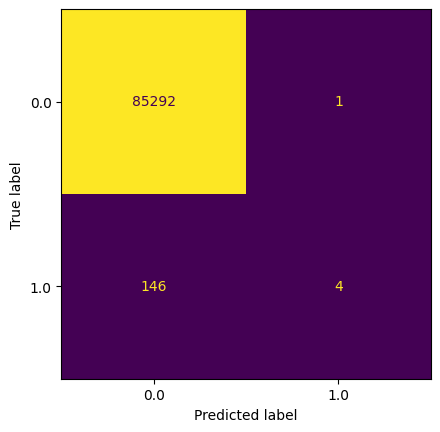

Test size: 85443
Model Accuracy:  0.997
Total Precision:  0.14
Total Recall:  0.107
Total F1 Score:  0.121
Log loss:  0.098
Confusion Matrix:



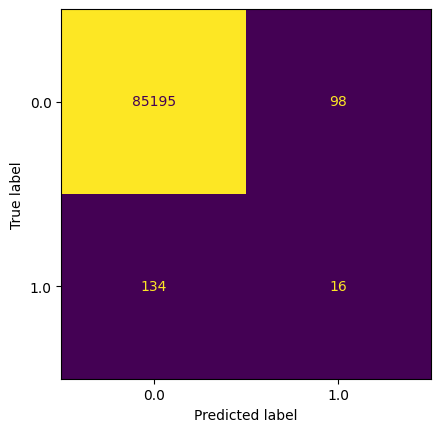

Test size: 85443
Model Accuracy:  0.647
Total Precision:  0.003
Total Recall:  0.64
Total F1 Score:  0.006
Log loss:  12.729
Confusion Matrix:



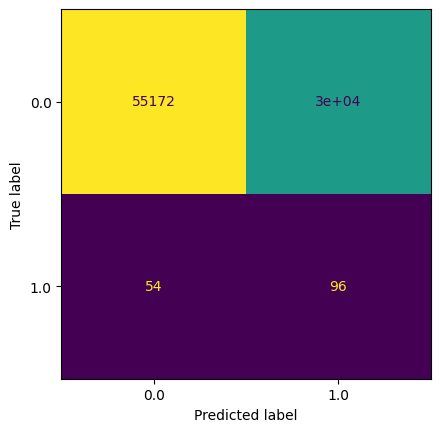

Test size: 85443
Model Accuracy:  0.946
Total Precision:  0.012
Total Recall:  0.36
Total F1 Score:  0.023
Log loss:  1.931
Confusion Matrix:



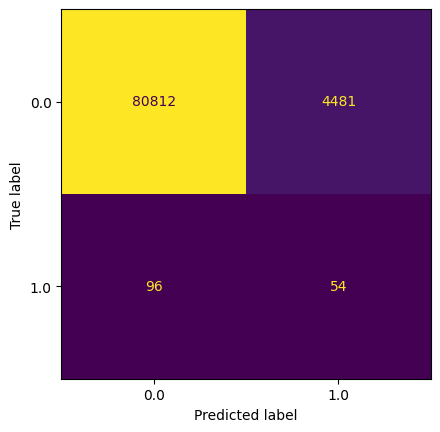

[I] [01:42:03.023822] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.067346] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.104717] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.146099] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.187785] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.227119] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.271530] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.310469] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.350458] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [01:42:03.388074] Unused keyword parameter: n_jobs during cuML estimator initialization
Test size: 85443
Model Accuracy:  0.998
Total Precision:  0.75
Total Recall:  0.

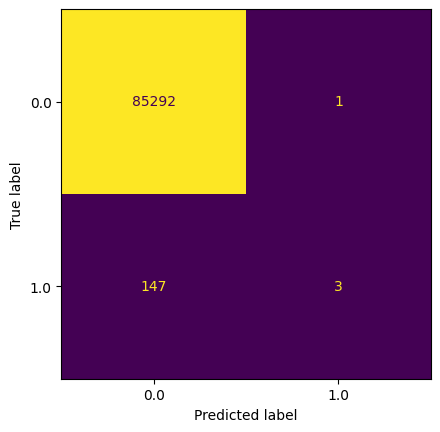

In [17]:
#Vanilla
# knn_class = KNeighborsClassifier(weights='distance')
# knn_class = KNeighborsClassifier()
knn_class = cuml.KNeighborsClassifier()

knn0 = train_test_model(knn_class, train_features, train_labels, val_features, val_labels, title = './outputs/kNN/kNN_vanilla')
#Oversampling
knn1 = train_test_model(knn_class, ovsp_features, ovsp_labels, val_features, val_labels, title = './outputs/kNN/kNN_ovsp')
#Undersampling
knn2 = train_test_model(knn_class, udsp_features, udsp_labels, val_features, val_labels, title = './outputs/kNN/kNN_udsp')
#SMOTE
knn3 = train_test_model(knn_class, smote_features, smote_labels, val_features, val_labels, title = './outputs/kNN/kNN_smote')
#Bagging
knn4 = train_test_model(BaggingClassifier(estimator=knn_class), train_features, train_labels, val_features, val_labels, title = './outputs/kNN/kNN_bagging')
#Boosting
# knn5 = train_test_model(AdaBoostClassifier(estimator=knn_class), train_features, train_labels, val_features, val_labels, title = './outputs/kNN/kNN_boosting')

In [10]:
pd.DataFrame(np.vstack([knn0, knn1, knn2, knn3, knn4]).T, index=metric_array, columns=['Vanilla', 'Over', 'Under', 'Smote', 'Bagging'])

,Vanilla,Over,Under,Smote,Bagging
Acc,0.998000,0.997000,0.650000,0.948000,0.998000
Prec,0.857143,0.139535,0.003043,0.011051,1.000000
Rec,0.040000,0.121000,0.611000,0.329000,0.027000
N Pred v,0.998326,0.998464,0.998956,0.998766,0.998303
FP rate*,0.000012,0.001301,0.349544,0.051410,0.000000
TN rate,0.999988,0.998699,0.650456,0.948590,1.000000
FN rate*,0.959732,0.879195,0.389262,0.671141,0.973154
FDisc r*,0.142857,0.860465,0.996957,0.988949,0.000000
F1,0.077000,0.129000,0.006000,0.021000,0.052000
Logl*,0.061000,0.102000,12.601000,1.892000,0.061000


Choose ovs

### Logistic Regression

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.836
Total Recall:  0.651
Total F1 Score:  0.732
Log loss:  0.03
Confusion Matrix:



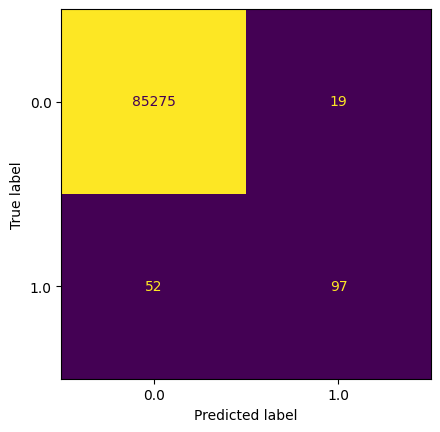

Test size: 85443
Model Accuracy:  0.966
Total Precision:  0.045
Total Recall:  0.913
Total F1 Score:  0.085
Log loss:  1.234
Confusion Matrix:



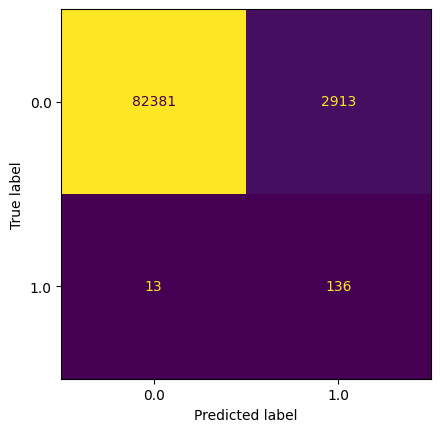

Test size: 85443
Model Accuracy:  0.962
Total Precision:  0.041
Total Recall:  0.913
Total F1 Score:  0.078
Log loss:  1.365
Confusion Matrix:



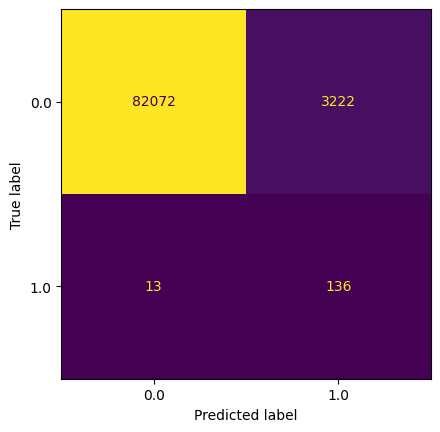

Test size: 85443
Model Accuracy:  0.982
Total Precision:  0.079
Total Recall:  0.899
Total F1 Score:  0.145
Log loss:  0.664
Confusion Matrix:



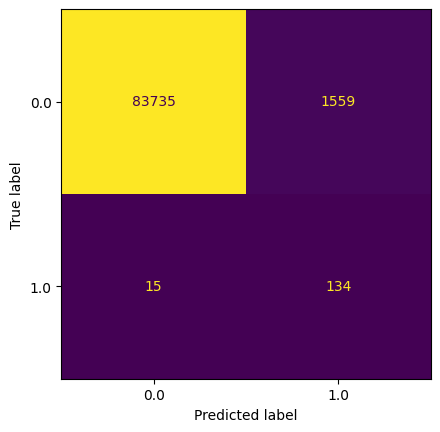

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.72
Total Recall:  0.691
Total F1 Score:  0.705
Log loss:  0.036
Confusion Matrix:



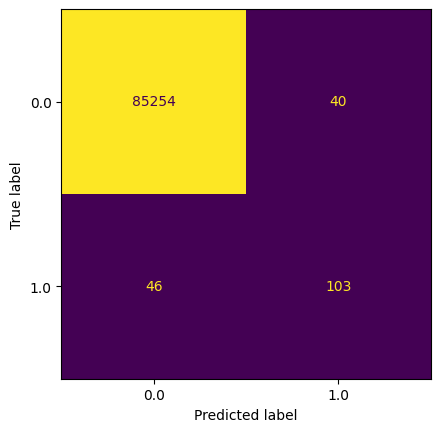

Test size: 85443
Model Accuracy:  0.998
Total Precision:  0.0
Total Recall:  0.0
Total F1 Score:  0.0
Log loss:  0.063
Confusion Matrix:



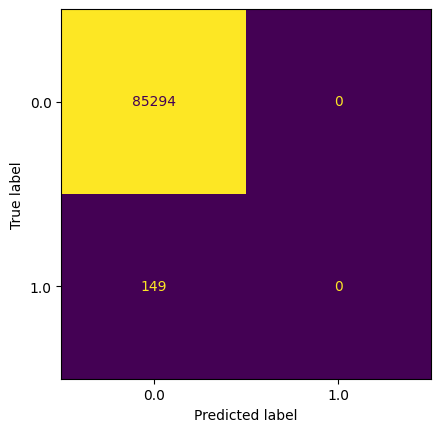

In [11]:
log_reg = cuml.LogisticRegression()
logreg0 = train_test_model(log_reg, train_features, train_labels, val_features, val_labels, title = './outputs/LogisticRegression/logreg_vanilla')
logreg1 = train_test_model(log_reg, ovsp_features, ovsp_labels, val_features, val_labels, title = './outputs/LogisticRegression/logreg_ovsp')
logreg2 = train_test_model(log_reg, udsp_features, udsp_labels, val_features, val_labels, title = './outputs/LogisticRegression/logreg_udsp')
logreg3 = train_test_model(log_reg, smote_features, smote_labels, val_features, val_labels, title = './outputs/LogisticRegression/logreg_smote')
logreg4 = train_test_model(BaggingClassifier(log_reg), train_features, train_labels, val_features, val_labels, title = './outputs/LogisticRegression/logreg_bag')
# logreg5 = train_test_model(AdaBoostClassifier(log_reg), train_features, train_labels, val_features, val_labels, title = './outputs/LogisticRegression/logreg_ada')

In [28]:
pd.DataFrame(np.vstack([logreg0, logreg1, logreg2, logreg3, logreg4]).T, index=metric_array, columns=['Vanilla', 'Over', 'Under', 'Smote', 'Bagging'])

,Vanilla,Over,Under,Smote,Bagging
Acc,0.999000,0.966000,0.962000,0.982000,0.999000
Prec,0.836207,0.044605,0.040500,0.079149,0.720280
Rec,0.651000,0.913000,0.913000,0.899000,0.691000
N Pred v,0.999391,0.999842,0.999842,0.999821,0.999461
FP rate*,0.000223,0.034152,0.037775,0.018278,0.000469
TN rate,0.999777,0.965848,0.962225,0.981722,0.999531
FN rate*,0.348993,0.087248,0.087248,0.100671,0.308725
FDisc r*,0.163793,0.955395,0.959500,0.920851,0.279720
F1,0.732000,0.085000,0.078000,0.145000,0.705000
Logl*,0.030000,1.234000,1.365000,0.664000,0.036000


Choose Bagging

### Naive Bayes

Test size: 85443
Model Accuracy:  0.993
Total Precision:  0.143
Total Recall:  0.631
Total F1 Score:  0.233
Log loss:  0.261
Confusion Matrix:



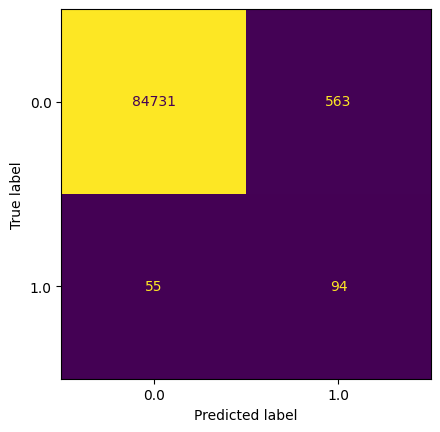

Test size: 85443
Model Accuracy:  0.991
Total Precision:  0.121
Total Recall:  0.705
Total F1 Score:  0.206
Log loss:  0.151
Confusion Matrix:



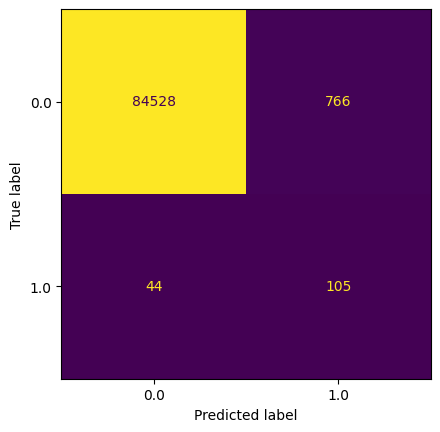

Test size: 85443
Model Accuracy:  0.989
Total Precision:  0.101
Total Recall:  0.698
Total F1 Score:  0.176
Log loss:  0.41
Confusion Matrix:



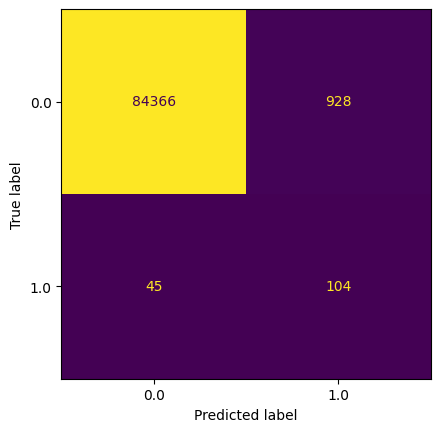

Test size: 85443
Model Accuracy:  0.992
Total Precision:  0.154
Total Recall:  0.745
Total F1 Score:  0.255
Log loss:  0.274
Confusion Matrix:



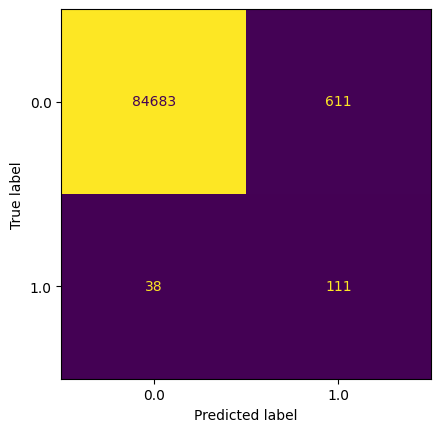

Test size: 85443
Model Accuracy:  0.993
Total Precision:  0.139
Total Recall:  0.624
Total F1 Score:  0.228
Log loss:  0.266
Confusion Matrix:



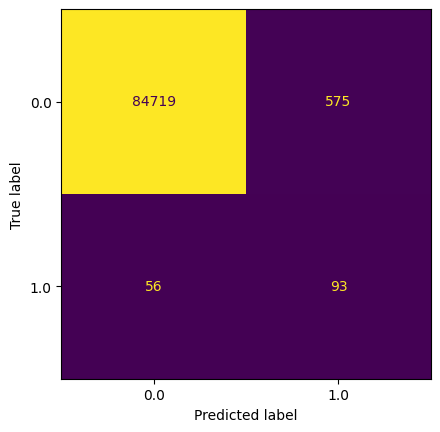

Test size: 85443
Model Accuracy:  0.998
Total Precision:  0.477
Total Recall:  0.477
Total F1 Score:  0.477
Log loss:  0.066
Confusion Matrix:



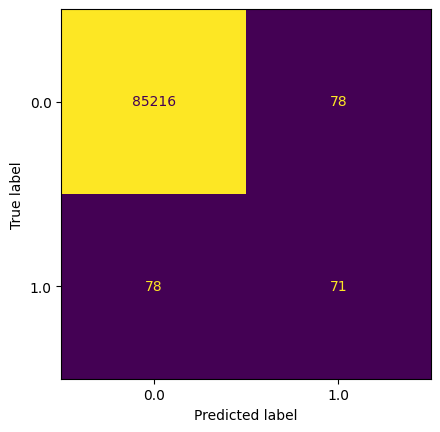

In [13]:
#Vanilla
# gnb_class = cuml.naive_bayes.GaussianNB()
gnb_class = GaussianNB()
gnb0 = train_test_model(gnb_class, train_features, train_labels, val_features, val_labels, title = './outputs/GNB/gnb_vanilla')
#Oversampling
gnb1 = train_test_model(gnb_class, ovsp_features.astype('float32'), ovsp_labels.astype('float32'), val_features.astype('float32'), val_labels.astype('float32'), title = './outputs/GNB/gnb_ovsp')
#Undersampling
gnb2 = train_test_model(gnb_class, udsp_features, udsp_labels, val_features, val_labels, title = './outputs/GNB/gnb_udsp')
#SMOTE
gnb3 = train_test_model(gnb_class, smote_features, smote_labels, val_features, val_labels, title = './outputs/GNB/gnb_smote')
#Bagging
gnb4 = train_test_model(BaggingClassifier(gnb_class), train_features, train_labels, val_features, val_labels, title = './outputs/GNB/gnb_bagging')
#Boosting
gnb5 = train_test_model(AdaBoostClassifier(gnb_class), train_features, train_labels, val_features, val_labels, title = './outputs/GNB/gnb_boosting')

In [14]:
pd.DataFrame(np.vstack([gnb0, gnb1, gnb2, gnb3, gnb4, gnb5]).T, index=metric_array, columns=['Vanilla', 'Over', 'Under', 'Smote', 'Bagging', 'AdaBoost'])

,Vanilla,Over,Under,Smote,Bagging,AdaBoost
Acc,0.993000,0.991000,0.989000,0.992000,0.993000,0.998000
Prec,0.143075,0.120551,0.100775,0.153740,0.139222,0.476510
Rec,0.631000,0.705000,0.698000,0.745000,0.624000,0.477000
N Pred v,0.999351,0.999480,0.999467,0.999551,0.999339,0.999086
FP rate*,0.006601,0.008981,0.010880,0.007163,0.006741,0.000914
TN rate,0.993399,0.991019,0.989120,0.992837,0.993259,0.999086
FN rate*,0.369128,0.295302,0.302013,0.255034,0.375839,0.523490
FDisc r*,0.856925,0.879449,0.899225,0.846260,0.860778,0.523490
F1,0.233000,0.206000,0.176000,0.255000,0.228000,0.477000
Logl*,0.261000,0.151000,0.410000,0.274000,0.266000,0.066000


Choose Boosting

### MLP

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.732
Total Recall:  0.473
Total F1 Score:  0.575
Log loss:  0.044
Confusion Matrix:



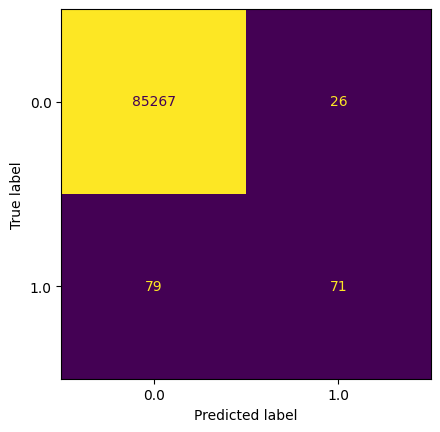

Test size: 85443
Model Accuracy:  0.965
Total Precision:  0.044
Total Recall:  0.92
Total F1 Score:  0.083
Log loss:  1.279
Confusion Matrix:



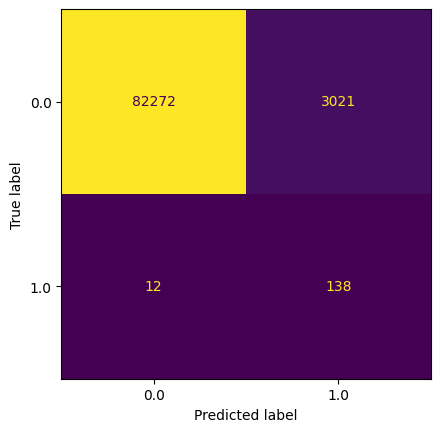

Test size: 85443
Model Accuracy:  0.003
Total Precision:  0.002
Total Recall:  1.0
Total F1 Score:  0.004
Log loss:  35.935
Confusion Matrix:



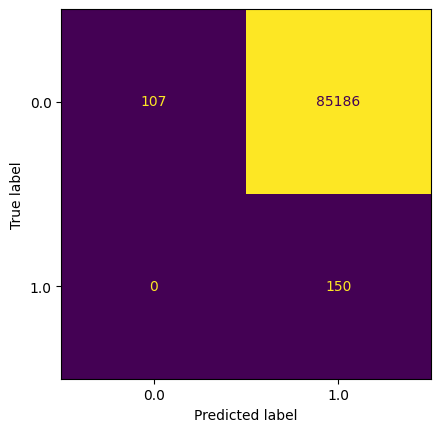

Test size: 85443
Model Accuracy:  0.99
Total Precision:  0.14
Total Recall:  0.907
Total F1 Score:  0.243
Log loss:  0.358
Confusion Matrix:



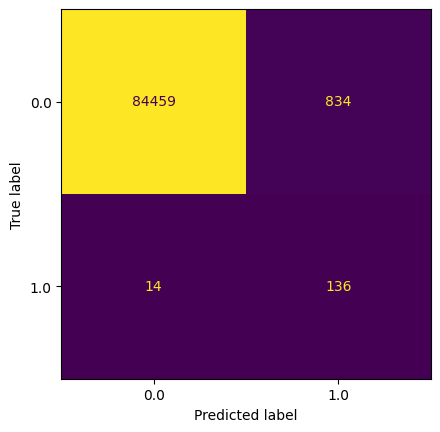

In [18]:
mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(100,))

#Vanilla
mlp0 = train_test_model(mlp, train_features, train_labels, val_features, val_labels, title = './outputs/MLP/mlp_vanilla')
#Oversampling
mlp1 = train_test_model(mlp, ovsp_features, ovsp_labels, val_features, val_labels, title = './outputs/MLP/mlp_ovsp')
#Undersampling
mlp2 = train_test_model(mlp, udsp_features, udsp_labels, val_features, val_labels, title = './outputs/MLP/mlp_udsp')
#SMOTE
mlp3 = train_test_model(mlp, smote_features, smote_labels, val_features, val_labels, title = './outputs/MLP/mlp_smote')
# #Bagging
# mlp4 = train_test_model(BaggingClassifier(mlp), train_features, train_labels, val_features, val_labels, title = './outputs/MLP/mlp_bagging')
# #Boosting
# mlp5 = train_test_model(AdaBoostClassifier(mlp), train_features, train_labels, val_features, val_labels, title = './outputs/MLP/mlp_boosting')

In [19]:
pd.DataFrame(np.vstack([mlp0, mlp1, mlp2, mlp3]).T, index=metric_array, columns=['Vanilla', 'Over', 'Under', 'Smote'])

,Vanilla,Over,Under,Smote
Acc,0.999000,0.965000,0.003000,0.990000
Prec,0.731959,0.043685,0.001758,0.140206
Rec,0.473000,0.920000,1.000000,0.907000
N Pred v,0.999074,0.999854,1.000000,0.999834
FP rate*,0.000305,0.035419,0.998746,0.009778
TN rate,0.999695,0.964581,0.001254,0.990222
FN rate*,0.526667,0.080000,0.000000,0.093333
FDisc r*,0.268041,0.956315,0.998242,0.859794
F1,0.575000,0.083000,0.004000,0.243000
Logl*,0.044000,1.279000,35.935000,0.358000


Choose smote

### Decision Tree

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.757
Total Recall:  0.752
Total F1 Score:  0.754
Log loss:  0.031
Confusion Matrix:



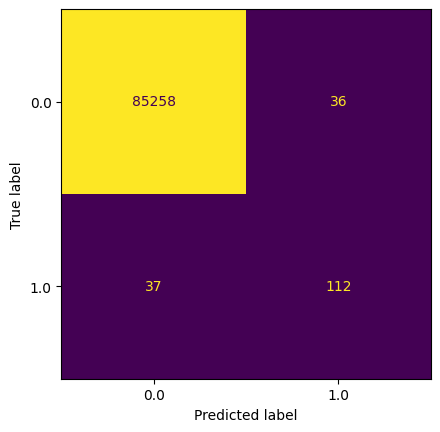

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.745
Total Recall:  0.765
Total F1 Score:  0.755
Log loss:  0.031
Confusion Matrix:



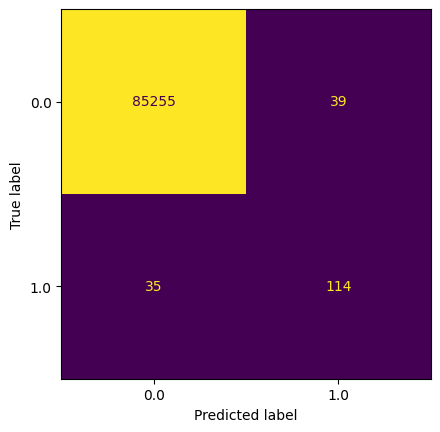

Test size: 85443
Model Accuracy:  0.901
Total Precision:  0.017
Total Recall:  0.96
Total F1 Score:  0.033
Log loss:  3.575
Confusion Matrix:



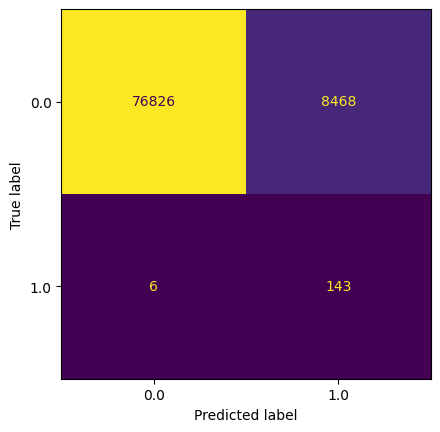

Test size: 85443
Model Accuracy:  0.998
Total Precision:  0.462
Total Recall:  0.819
Total F1 Score:  0.591
Log loss:  0.071
Confusion Matrix:



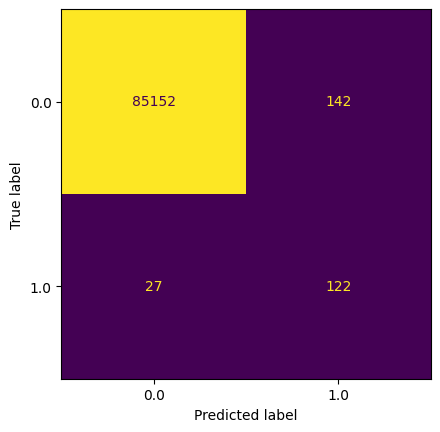

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.942
Total Recall:  0.758
Total F1 Score:  0.84
Log loss:  0.018
Confusion Matrix:



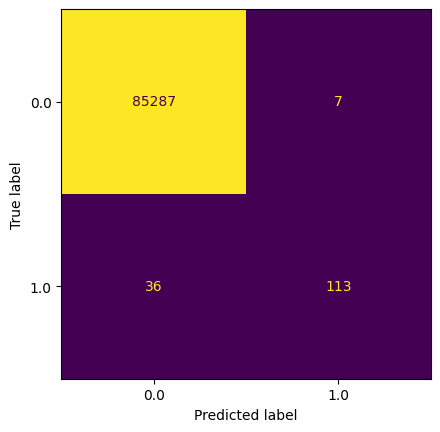

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.813
Total Recall:  0.758
Total F1 Score:  0.785
Log loss:  0.026
Confusion Matrix:



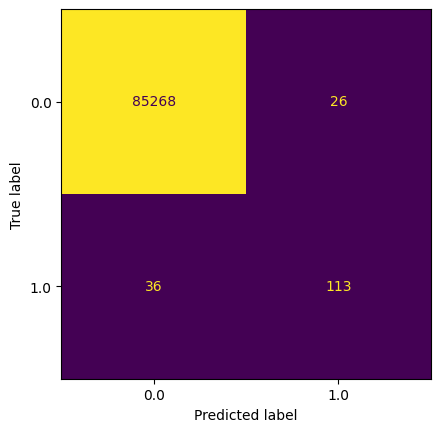

In [23]:
dt = DecisionTreeClassifier()

dt0 = train_test_model(dt, train_features, train_labels, val_features, val_labels, title = './outputs/Dtree/dt_vanilla')
dt1 = train_test_model(dt, ovsp_features, ovsp_labels, val_features, val_labels, title = './outputs/Dtree/dt_ovsp')
dt2 = train_test_model(dt, udsp_features, udsp_labels, val_features, val_labels, title = './outputs/Dtree/dt_udsp')
dt3 = train_test_model(dt, smote_features, smote_labels, val_features, val_labels, title = './outputs/Dtree/dt_smote')
dt4 = train_test_model(BaggingClassifier(dt), train_features, train_labels, val_features, val_labels, title = './outputs/Dtree/dt_bag')
dt5 = train_test_model(AdaBoostClassifier(dt), train_features, train_labels, val_features, val_labels, title = './outputs/Dtree/dt_ada')

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.714
Total Recall:  0.235
Total F1 Score:  0.354
Log loss:  0.054
Confusion Matrix:



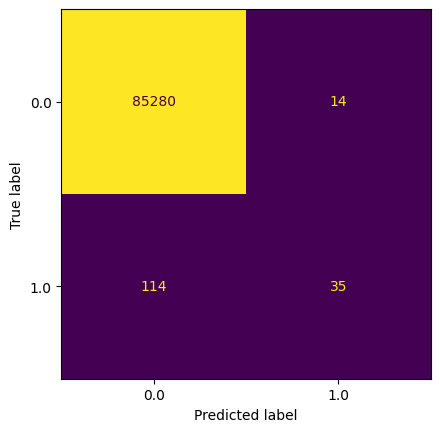

In [26]:
dt6 = train_test_model(GradientBoostingClassifier(), train_features, train_labels, val_features, val_labels, title = './outputs/Dtree/dt_gboost')

In [27]:
pd.DataFrame(np.vstack([dt0, dt1, dt2, dt3, dt4, dt5]).T, index=metric_array, columns=['Vanilla', 'Over', 'Under', 'Smote', 'Bagging', 'AdaBoost'])

,Vanilla,Over,Under,Smote,Bagging,AdaBoost,GradientBoost
Acc,0.999000,0.999000,0.901000,0.998000,0.999000,0.999000,0.999000
Prec,0.756757,0.745098,0.016607,0.462121,0.941667,0.812950,0.714286
Rec,0.752000,0.765000,0.960000,0.819000,0.758000,0.758000,0.235000
N Pred v,0.999566,0.999590,0.999922,0.999683,0.999578,0.999578,0.998665
FP rate*,0.000422,0.000457,0.099280,0.001665,0.000082,0.000305,0.000164
TN rate,0.999578,0.999543,0.900720,0.998335,0.999918,0.999695,0.999836
FN rate*,0.248322,0.234899,0.040268,0.181208,0.241611,0.241611,0.765101
FDisc r*,0.243243,0.254902,0.983393,0.537879,0.058333,0.187050,0.285714
F1,0.754000,0.755000,0.033000,0.591000,0.840000,0.785000,0.354000
Logl*,0.031000,0.031000,3.575000,0.071000,0.018000,0.026000,0.054000


Choose Bagging

Test size: 85443
Model Accuracy:  0.992
Total Precision:  0.128
Total Recall:  0.714
Total F1 Score:  0.217
Log loss:  0.275
Confusion Matrix:



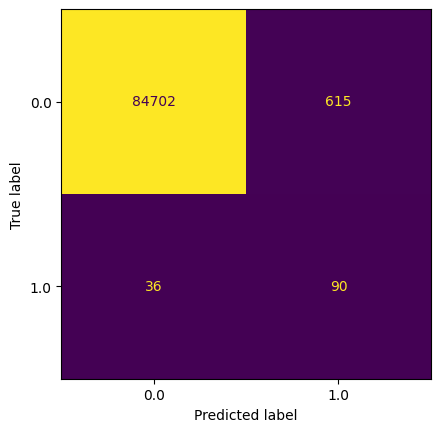

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.694
Total Recall:  0.794
Total F1 Score:  0.741
Log loss:  0.03
Confusion Matrix:



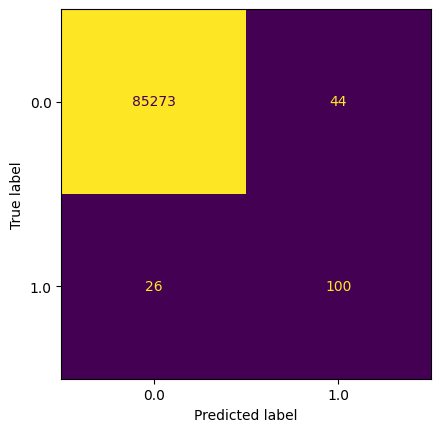

Test size: 85443
Model Accuracy:  0.999
Total Precision:  1.0
Total Recall:  0.032
Total F1 Score:  0.062
Log loss:  0.051
Confusion Matrix:



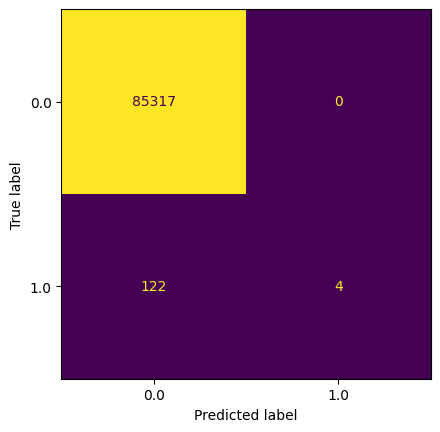

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.0
Total Recall:  0.0
Total F1 Score:  0.0
Log loss:  0.053
Confusion Matrix:



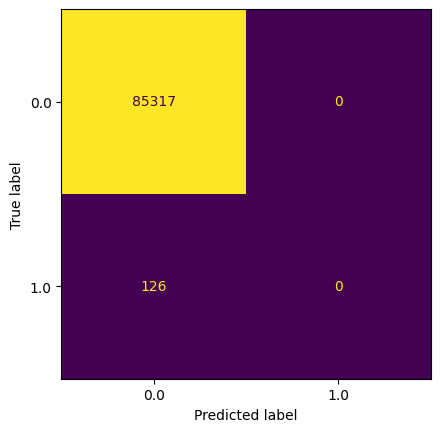

Test size: 85443
Model Accuracy:  0.999
Total Precision:  0.703
Total Recall:  0.77
Total F1 Score:  0.735
Log loss:  0.03
Confusion Matrix:



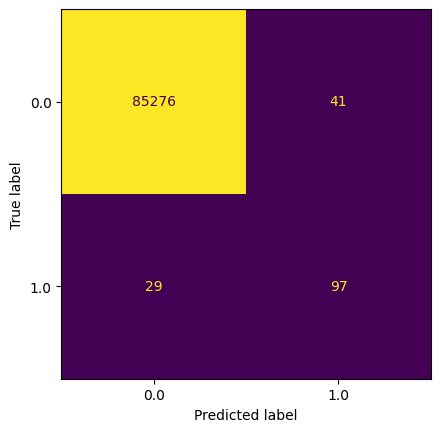

Test size: 85443
Model Accuracy:  0.998
Total Precision:  0.356
Total Recall:  0.841
Total F1 Score:  0.5
Log loss:  0.089
Confusion Matrix:



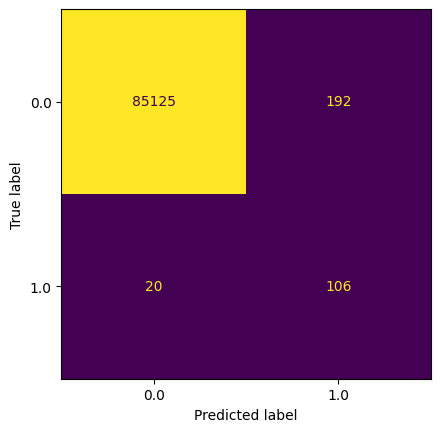

In [7]:
gnb0 = train_test_model(GaussianNB(), train_features, train_labels, val_features, val_labels, title = './outputs/GNB/gnb_vanilla')
dt0 = train_test_model(DecisionTreeClassifier(), train_features, train_labels, val_features, val_labels, title = './outputs/Dtree/dt_vanilla')
knn0 = train_test_model(cuml.KNeighborsClassifier(), train_features, train_labels, val_features, val_labels, title = './outputs/kNN/kNN_vanilla')
svm0 = train_test_model(cuml.svm.SVC(), train_features, train_labels, val_features, val_labels, title = './outputs/SVM/SVM_vanilla')
logreg0 = train_test_model(cuml.LogisticRegression(), train_features, train_labels, val_features, val_labels, title = './outputs/LogisticRegression/logreg_vanilla')
mlp0 = train_test_model(MLPClassifier(), train_features, train_labels, val_features, val_labels, title = './outputs/MLP/mlp_vanilla')


In [15]:
pd.DataFrame(np.vstack([gnb0, dt0, mlp0]).T, index=['Accuracy', 'Precision', 'Recall', 'NPV', 'FPR', 'TNR', 'FNR', 'FDR', 'F1', 'LogLoss'], columns=['GNB', 'Dtree','MLP']).round(3).to_latex('./outputs/inter.tex')